# ASU HRT Workshop - Landlab Use Case Part 2

## Introduction

Overland flow, particularly the infiltration-excess mechanism, is affected by the nature of water input through precipitation. This Jupyter notebook demonstrates how to use the high resolution topography data and Landlab model components to delineate the watershed and simulate the overland flow for a study area in the Boulder County. 

In this notebook, it includes the following sections:
- [Initial Setup](#setup)
  
  This section will install Python packages and create the input/output folders.
  <br>
- [Step 1: OpenTopography Data](#step1) 

  This section will load the topography datasets with 30m resolution and 1m resolution for the study area.
  <br>
- [Step 2: Delineate Watershed](#step2)

  This section will use the topography dataset (1m resolution) and Landlab components to delineate the watershed for the study area. 
  <br>
- [Step 3: Calculate Overland Flow](#step3)

  This section will use the watershed topography data and Landlab overlandflow component to simulate the surface water depth and discharge.
  <br>
- [Step 4: Visualize Results](#step4)

  This section will visualize the final results as a short video.


<a id='setup'></a>
## Initial Setup

### Install Packages (on Local PC)
If you want to run this notebook on your PC, you can run the following command which will create a separate conda environment named "overland_flow" and install all the required packages for you. After the installation, please make sure to activate the environment to run this notebook.

In [1]:
! conda env create --file=environment.yml


CondaValueError: prefix already exists: /Users/tiga7385/opt/anaconda3/envs/overland_flow



### Create Folder
We will first import all the python packages and create a result folder for this notebook.

In [2]:
# import packages 
import os
import warnings

import numpy as np
import pandas as pd
import xarray
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio.v2 as imageio
from IPython.display import Video

from pymt.models import Topography, Era5
from bmi_geotiff import GeoTiff
from landlab import RasterModelGrid, imshow_grid, imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.drainage_plot import drainage_plot
from landlab.utils import get_watershed_mask

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# create result folder
results_dir = os.path.join(os.getcwd(), 'results_betasso') 

if not os.path.isdir(results_dir):
    os.mkdir(results_dir)
    
print(results_dir)


/Users/tiga7385/Desktop/ASU_tutorial/results_betasso


<a id='step1'></a>
## Step 1 OpenTopography Data

### Study Area
Betasso is situated in the lower Boulder Canyon, just 6 miles west of City of Boulder. This area is a mix of steep forested slopes with several intermittent streams, and sloping meadows, sub-summits, and rock outcrops. The south facing slopes are primarily warmer with Ponderosa Pine stands. The cooler north-facing slopes are a Ponderosa Pine-Douglas fir mix. The Boulder Filtration Plant is located just outside the Betasso Preserve. For more details please check [here](https://czo-archive.criticalzone.org/boulder/infrastructure/field-area/betasso/).

<img src="https://czo-archive.criticalzone.org/images/made/images/national/photos-and-images/Boulder/Betasso/IMGP1431_640_480_80auto.jpg" width="800">

### 30m DEM

We will first use the CSDMS [Topography data component](https://csdms.colorado.edu/wiki/Model:Topography_Data_Component) to download the 30m DEM for the study area from [OpenTopography](https://opentopography.org/developers). The following cells demonstrate how to use the configuration file ('betasso_config.yaml') to initialize a data component to download the dataset and how to use the variable and grid related methods of this data component to get the metadata as well as the data values. 

This subsection demonstrates how to use the CSDMS data component to access the global topography data from OpenTopography. In the next subsection, we will load the 1m topography dataset for watershed delineation. 

In [4]:
# initialize Topography data component
dem = Topography()
dem.initialize('betasso_config.yaml')

*Got the HTTPError? Double-click __here__ for the solution.*

<!-- 

If you get 'HTTPError: 401 Client Error', you will need to create an API key file to download the dataset. Please make sure you first request an Open Topography API Key(https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets). 

Then copy and paste the following code in a new cell and run it. The install_api_key( ) function will ask for your Open Topography API Key to create the API key file for you. Please make sure you provide the correct API Key information. 

from utils import install_api_key
install_api_key()

-->

In [5]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_type: int16 
var_grid: 0 
var_itemsize: 2
var_nbytes: 2940 



In [6]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)
xy_spacing = 30.0


print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [35 42] 
grid_spacing: [ 0.00027778  0.00027778] 
grid_origin: [  40.0075     -105.34444444]


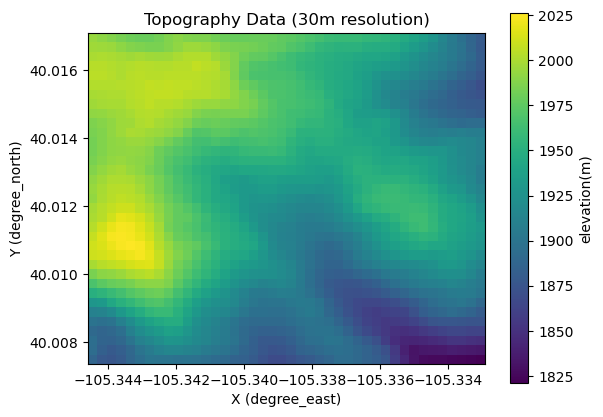

In [7]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1)
im = ax.imshow(dem_data_2D, extent=extent)
ax.title.set_text('Topography Data (30m resolution)')
ax.ticklabel_format(useOffset=False)
ax.set_xlabel('X (degree_east)')
ax.set_ylabel('Y (degree_north)')
fig.colorbar(im,label='elevation(m)')

### 1m DEM

For watershed delineation, we will use the 1m topography dataset as the input. This dataset is a subset from the data product of [Boulder Creek Critical Zone Observatory August 2010 LiDAR Survey](https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.032012.26913.1). We have already downloaded this dataset and will use the [GeoTiff data component](https://csdms.colorado.edu/wiki/Model:GeoTiff_Data_Component) to load the dataset. 

In [8]:
# Load topography data
data_comp = GeoTiff('betasso_1m.tif')

In [9]:
# get grid shape and data values
dem_grid_shape = data_comp.da.shape
print('grid shape: {}'.format(dem_grid_shape))
dem_data = data_comp.da.values

grid shape: (1070, 1000)


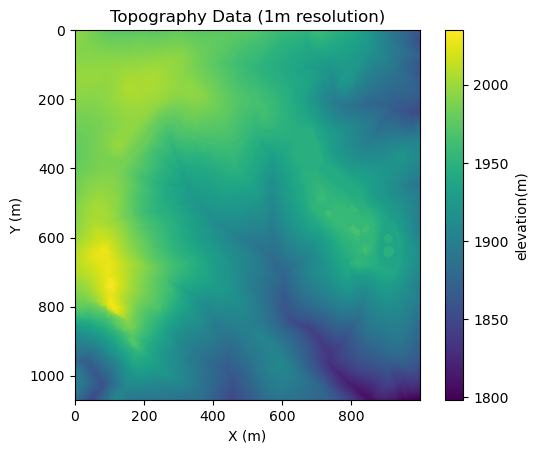

In [10]:
# plot DEM data
fig, ax = plt.subplots(1,1)
im = ax.imshow(dem_data)
ax.title.set_text('Topography Data (1m resolution)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
fig.colorbar(im,label='elevation(m)')

<a id='step2'></a>
## Step 2 Delineate Watershed

We will use the 1m topography dataset for watershed delineation. The Landlab components ([FlowAccumulator](https://landlab.readthedocs.io/en/master/reference/components/flow_accum.html) and [ChannelProfiler](https://landlab.readthedocs.io/en/master/reference/components/channel_profiler.html)) and the Landlab utility ([get_watershed_mask](https://landlab.readthedocs.io/en/master/reference/utils/watershed.html)) will be used to accomplish this task. 

The general steps for watershed delineation include: 
- Setup raster model grid and add topographic elevation data field
- Calculate the flow accumulation
- Get watershed mask
- Set watershed boundary 

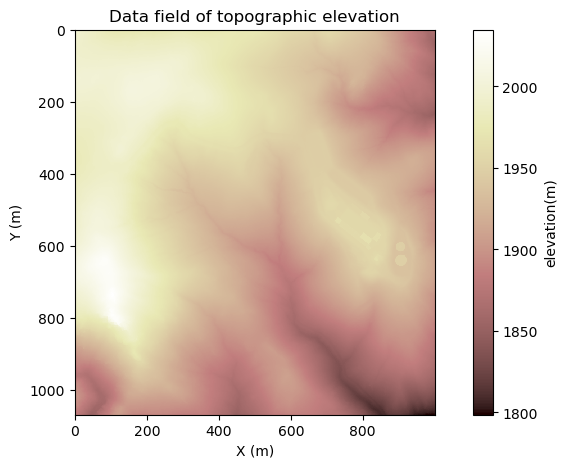

In [11]:
# set the grid resolution (m)
grid_resolution = 1.0 

# set up raster model grid 
model_grid = RasterModelGrid(dem_grid_shape, xy_spacing=grid_resolution) 

# add topographic elevation data field
dem_field = model_grid.add_field("topographic__elevation", dem_data.astype('float'))

# plot the topographic elevation data field
plt.figure(figsize=(10,5))
ax = plt.gca()
imshow_grid(model_grid,
            'topographic__elevation',
            plot_name='Data field of topographic elevation',
            var_name='elevation(m)'
            )
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.invert_yaxis()

In [12]:
# calculate the flow accumulation
fa=FlowAccumulator( model_grid, method='Steepest', 
                    flow_director='FlowDirectorSteepest', 
                    depression_finder='LakeMapperBarnes',
                    redirect_flow_steepest_descent=True,
                    reaccumulate_flow=True)
fa.run_one_step()  

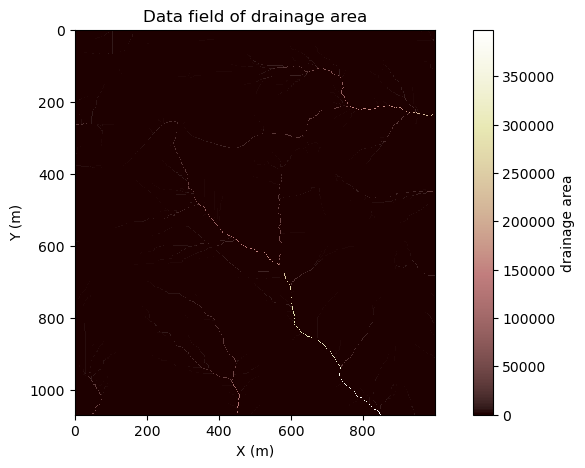

In [13]:
# plot the flow accumulation result
plt.figure(figsize=(10,5))
ax = plt.gca()
imshow_grid(model_grid, 'drainage_area', 
            plot_name='Data field of drainage area',
            var_name='drainage area'
            )
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.invert_yaxis()

In [14]:
# set up channel profiler 
profiler = ChannelProfiler(model_grid,number_of_watersheds=1)
profiler.run_one_step()

In [15]:
# get watershed mask
outlet = profiler.nodes[0][0]
watershed_mask = get_watershed_mask(model_grid, outlet)

In [16]:
# set watershed boundary
dem_field[~watershed_mask] = -9999.0
model_grid.status_at_node[np.isclose(dem_field, -9999.0)] = model_grid.BC_NODE_IS_CLOSED
model_grid.status_at_node[outlet] = model_grid.BC_NODE_IS_FIXED_VALUE

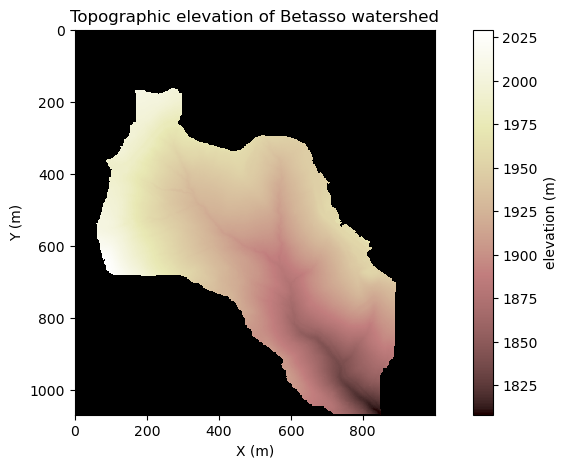

In [17]:
# plot the watershed 
plt.figure(figsize=(10,5))
ax = plt.gca()
imshow_grid_at_node(model_grid, dem_field, 
                    plot_name='Topographic elevation of Betasso watershed',
                    colorbar_label="elevation (m)")
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.invert_yaxis()

<a id='step3'></a>
## Step 3  Calculate Overland Flow

In this step, the watershed topography dataset and the Landlab [Overland Flow component](https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html#background-on-overlandflow-component) will be used for the simulation. The model run time is set as 20 min with the first 2 min assigned with a constant rainfall intensity (100 mm/hr). This rain intensity value is based on the observational data from an overland flow event that happened in Betasso watershed on Aug 30th, 2016. The simulation results will create a discharge time series plot at the outlet and a 2D plot of the surface water depth at each 60 sec time step.

In this simulation, we suppose there is no water infiltration process involved. Is this justified? Not really, this is a model simplification for demonstration purposes. So this assumption provides an end-member case of extreme soil water repellency in the watershed.



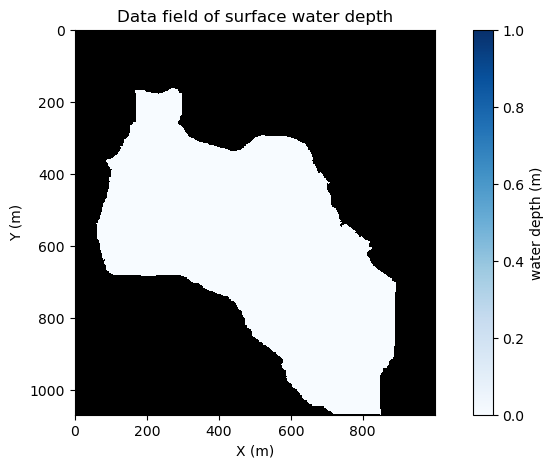

In [18]:
# add surface wate depth data field 
model_grid.add_zeros("surface_water__depth", at="node", clobber=True)

# set initial surface water depth value
model_grid.at_node["surface_water__depth"].fill(
    1e-12
) 

plt.figure(figsize=(10,5))
ax = plt.gca()
imshow_grid(model_grid,'surface_water__depth', 
            plot_name='Data field of surface water depth',
            var_name='water depth (m)',
            cmap="Blues", vmin=0.0,vmax=1)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.invert_yaxis()

In [19]:
# instantiate overland flow component
overland_flow = OverlandFlow(
    model_grid, steep_slopes=True
)

# set model run parameters (may take 15 min for simulation)
elapsed_time = 0.0
model_run_time = 20 * 60  # duration of run (s) 
storm_duration = 2 * 60  # duration of rain (s) 
time_step = 60   
rainfall_intensity = 100 /(1000*3600)  # mm/hr to m/s 

outlet_discharge = []
outlet_times = []

# run overland flow simulation
print(datetime.now())

for time_slice in range(time_step, model_run_time + time_step, time_step):
    print(time_slice)
    
    while elapsed_time < time_slice:
        
        # get adaptive time step 
        overland_flow.dt = min(overland_flow.calc_time_step(), time_slice)  

        # set rainfall intensity
        if elapsed_time < (storm_duration):           
            overland_flow.rainfall_intensity =  rainfall_intensity
        else:
            overland_flow.rainfall_intensity = 0.0

        # run model 
        overland_flow.overland_flow(dt=overland_flow.dt)
        #print('dt:', overland_flow.dt)
        
        # update elapsed time
        elapsed_time += overland_flow.dt
        
        # get discharge result
        discharge= overland_flow.discharge_mapper(
                        model_grid.at_link['surface_water__discharge'], 
                        convert_to_volume=True
        )
        
        outlet_discharge.append(discharge[outlet])
        outlet_times.append(elapsed_time)
        
    # plot result
    fig, ax = plt.subplots(2,1,figsize=(8,9), gridspec_kw={'height_ratios': [1, 1.5]})
    fig.suptitle("Results at {} min".format(time_slice/60))

    ax[0].plot(outlet_times, outlet_discharge,'-')
    ax[0].set_xlabel("Time elapsed (s)")
    ax[0].set_ylabel("discharge (cms)")
    ax[0].set_title("Water discharge at the outlet")

    imshow_grid_at_node(model_grid, "surface_water__depth",
                        cmap="Blues", 
                        vmin=0, vmax=0.5, 
                        var_name="surface water depth (m)")
    ax[1].set_title('')
    ax[1].invert_yaxis()
    ax[1].set_xlabel('X (m)')
    ax[1].set_ylabel('Y (m)')

    plt.close(fig)
    fig.savefig(os.path.join(results_dir, 'flow_{}.png'.format(time_slice)))
    
print(datetime.now())
print('Simulation is done')

2023-02-14 16:20:08.236921
60
120
180
240
300
360
420
480
540
600
660
720
780
840
900
960
1020
1080
1140
1200
2023-02-14 16:36:15.249732
Simulation is done


<a id='step4'></a>
## Step 4 Visualize Results

Run the cells below and it will show a short video. You will be able to see the changes of the surface water depth over the watershed and the discharge at the outlet over the simulation time. 

You can also reset the value for the "model_run_time" variable with a larger value so that you will be able to see the whole process of the rainwater draining out of this watershed.

In [20]:
# Make a short video
img_files = [os.path.join(results_dir, file) for file in os.listdir(results_dir) if '.png' in file]
img_files.sort(key=lambda x: os.path.getmtime(x))

video_file = os.path.join(results_dir,'overland_flow.mp4')

with imageio.get_writer(os.path.join(video_file), mode='I', fps=1,macro_block_size=None ) as writer:
    for f in img_files:
        im = imageio.imread(os.path.join(results_dir, f))
        writer.append_data(im)

writer.close()

[rawvideo @ 0x7f9c6b80fc00] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [21]:
# Display the video
Video(video_file, embed=True, width=790, height=700)

## References
- Adams, J. M., Gasparini, N. M., Hobley, D. E. J., Tucker, G. E., Hutton, E. W. H., Nudurupati, S. S., and Istanbulluoglu, E.: The Landlab v1.0 OverlandFlow component: a Python tool for computing shallow-water flow across watersheds, Geosci. Model Dev., 10, 1645–1663, https://doi.org/10.5194/gmd-10-1645-2017, 2017.

- de Almeida, G. A., Bates, P., Freer, J. E., & Souvignet, M. (2012). Improving the stability of a simple formulation of the shallow water equations for 2‐D flood modeling. Water Resources Research, 48(5).
- Boulder Creek Critical Zone Observatory August 2010 LiDAR Survey. Distributed by OpenTopography. https://doi.org/10.5069/G93R0QR0 . Accessed: 2023-02-07